In [45]:
import numpy as np
import pandas as pd

import sqlite3
from datetime import timedelta
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 3)

MAX_INGRESS_P = 12000
MAX_INGRESS_N = 1000
MAX_EGRESS_P = 12000
MAX_EGRESS_N = 1000

#Always starts with a clean table to store python
#data cleaning results 
def create_clean_table(table_name):
    conn = sqlite3.connect('mta.db')

    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    conn.commit()
    cursor.execute('''CREATE TABLE {}(
    UNIT TEXT, SCP TEXT, CA TEXT, STATION TEXT,
    LINENAME TEXT, ENTRIES INTEGER,EXITS INTEGER,
    Year INTEGER, Week INTEGER,
    PRIMARY KEY(UNIT,SCP,CA,STATION,LINENAME,Year,Week)
    );'''.format(table_name))
    conn.commit()
    conn.close()
    return

def proj1_clean(datafile):
    df=pd.read_csv(datafile,converters={'DATE':pd.to_datetime})
    df.columns = [column.strip() for column in df.columns]
    df['Ingress'] = df['ENTRIES'].diff()
    df['Egress']= df.iloc[:,10].diff()
    errcnt=[0]*7
    max_row = len(df)  
    
    full_unit_name= df['UNIT'] + df['SCP']
    full_unit1 = full_unit_name.shift(1)
    
    #boolean series indicates if current row is the same turnstile as previous row
    same_unit = full_unit1.eq(full_unit_name)
    df.iloc[0,11] = 0
    df.iloc[0,12] = 0
 
    # Set Ingress to 0 for any row when it is not the same unit as the result
    # of diff() from above is only valid for rows belong to the same unit
    df['Ingress'] = df['Ingress'] * same_unit  #element wise multiply with 1/0    
    df['Egress'] = df['Egress'] * same_unit

    # Set Ingress to -(Ingress) for any row if  Ingress  < 0 
    # and the next row is also negative. This account for persistent counting down
    # for counters installed incorrectly
    smallN_Check = df['Ingress'] <= 0
    shifted=smallN_Check.shift(-1)
    shifted[max_row-1]=False
    df['Ingress'] = (1-(smallN_Check & shifted) *2) * df['Ingress']
    errcnt[0] = smallN_Check.sum()
    
    # Set Ingress to 0 for any row when it is > MAX_INGRESS_P    
    Max_Check = df['Ingress'] < MAX_INGRESS_P
    # Set Ingress to 0 for any row when it is < -MAX_INGRESS_N    
    MaxN_Check = df['Ingress'] > -MAX_INGRESS_N
    df['Ingress'] = df['Ingress'] * MaxN_Check * Max_Check  #element wise multiply with 1/0
    saved_mask = MaxN_Check & Max_Check
    errcnt[1] = max_row - Max_Check.sum()
    errcnt[2] = max_row - MaxN_Check.sum()  

    
    # Set Egress to -(Engress) for any row when  Engress <0       
    smallN_Check = df['Egress'] <= 0
    shifted=smallN_Check.shift(-1)
    shifted[max_row-1]=False
    df['Egress'] = (1-(smallN_Check & shifted) *2) * df['Egress']  
    errcnt[3] = smallN_Check.sum()
    
    # Set Egress to 0 for any row when it is > MAX_EGRESS_P    
    Max_Check = df['Egress'] < MAX_EGRESS_P
    # Set Engress to 0 for any row when it is < -MAX_EGRESS_N    
    MaxN_Check = df['Egress'] > -MAX_EGRESS_N
    df['Egress'] = df['Egress'] * MaxN_Check * Max_Check  #element wise multiply with 1/0
    saved_mask = saved_mask & MaxN_Check & Max_Check
    errcnt[4] = max_row - Max_Check.sum()
    errcnt[5] = max_row - MaxN_Check.sum()
    
    #This includes all the main correction made to the Ingress/Egress data 
    df['Mask']=~saved_mask    
#    df['Week']=df.DATE.dt.isocalendar().week
#    df['DATE_TIME']=pd.to_datetime(df['DATE']+df['TIME'],format='%m/%d/%Y%H:%M:%S') 
    df['Net']=df['Ingress']-df['Egress'] 
    weekly=df.groupby(['UNIT','SCP','C/A','STATION','LINENAME'])[['Ingress','Egress']].sum().reset_index()
    
    #Add date to the weekly result 
    weekly['Year']=year=df.loc[0,'DATE'].isocalendar()[0]
    weekly['Week']=week=df.loc[0,'DATE'].isocalendar()[1]
    return errcnt,df,weekly

In [4]:
datafiles=['210612','210313','201205','200912','200613','200307','191207','190615','181208','180609','170610','160611','150613']
for name in datafiles:
    datafile='http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(name)
    errcnt,df,w1=proj1_clean(datafile)
    print(errcnt)
    w1.to_csv('mta{}_{}.csv'.format(w1.loc[0,'Year'],w1.loc[0,'Week']),
              header=False,index=False)

In [76]:
#!echo "UNIT,SCP,CA,STATION,LINENAME,ENTRIES,EXITS,Year,Week" >mta0.csv
!rm mta.csv
!cat *.csv >> mta.csv
create_clean_table('mta_station')
#import mta.csv into table mta_station using sqlite3 i.e.
#.move csv
#.import mta.csv mta_station
#week=pd.read_csv('mta.csv')

First we need to process the raw data and save the per week data into the database. Here we read the finished data out of database.

In [63]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

engine = create_engine("sqlite:///mta.db")

In [5]:
mta_week=pd.read_sql('''SELECT Year, SUM(ENTRIES) Ent, SUM(EXITS) Ext 
FROM mta_station WHERE Week between 20 AND 25 GROUP BY Year;'''
    , engine)

In [6]:
mta_week['Net']=mta_week['Ent']-mta_week['Ext']
mta_week['Total']=mta_week['Ent']+mta_week['Ext']

From this Figure, total subway ridership per week dropped from around 60 millions pre-COVID, to 15 million per week at worst, and has sinced recovered to near 30 millions per week.
One point to note is that, entries used to be larger than exits by a large margin, and this trend ahs reversed post COVID.
In figure 2, we can see entries used to be about 56% of total traffic, while exits only account for 44% total traffic. This is been reversed post COVID.

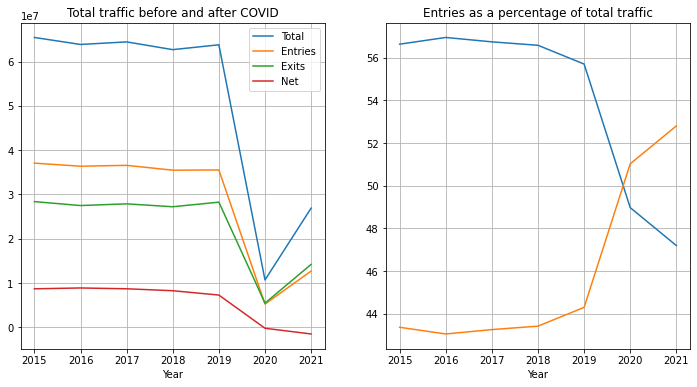

In [32]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Total traffic before and after COVID')
plt.plot(mta_week.Year,mta_week.Total,label='Total')
plt.plot(mta_week.Year,mta_week.Ent,label='Entries')
plt.plot(mta_week.Year,mta_week.Ext,label='Exits')
plt.plot(mta_week.Year,mta_week.Net,label='Net')
plt.xlabel('Year')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(mta_week.Year,mta_week.Ent/mta_week.Total * 100,label='Entries')
plt.plot(mta_week.Year,mta_week.Ext/mta_week.Total * 100,label='Exits')
plt.title('Entries as a percentage of total traffic')
plt.xlabel('Year');
plt.grid()
plt.savefig('total.png',dpi=150,transparent=False)


In [82]:
mta_week=pd.read_sql('''SELECT Year, Week, SUM(ENTRIES) Ent, SUM(EXITS) Ext 
FROM mta_station 
WHERE Year >= 2019
GROUP BY Year,Week;''', engine)

In [87]:
mta_week

,Year,WEEK,Ent,Ext,Net,Total
0,2019,23,35531788,28254148,7277640,63785936
1,2019,48,35526111,28432868,7093243,63958979
2,2020,9,33082525,27164893,5917632,60247418
3,2020,23,5236345,5456133,-219788,10692478
4,2020,36,8960336,9175020,-214684,18135356
5,2020,48,9729892,10003448,-273556,19733340
6,2021,9,10208213,10936083,-727870,21144296
7,2021,22,12696031,14205228,-1509197,26901259


In [84]:
mta_week['Net']=mta_week['Ent']-mta_week['Ext']
mta_week['Total']=mta_week['Ent']+mta_week['Ext']
#mta_week['Date']=mta_week.Year*56+mta_week.WeeK

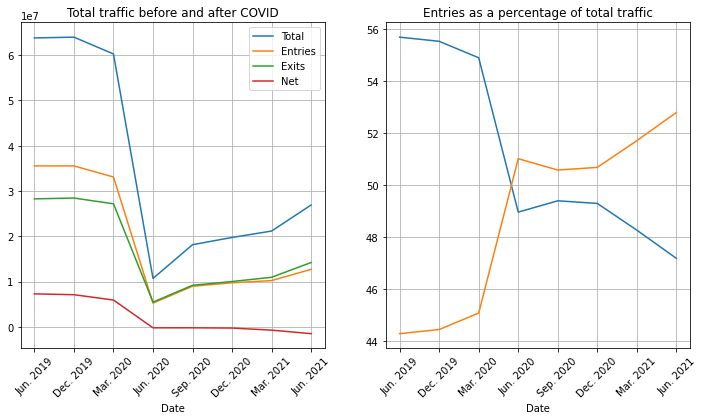

In [92]:
plt.figure(figsize=[12,6])
x=np.arange(0,8)
plt.subplot(1,2,1)
plt.title('Total traffic before and after COVID')
plt.plot(x,mta_week.Total,label='Total')
plt.plot(x,mta_week.Ent,label='Entries')
plt.plot(x,mta_week.Ext,label='Exits')
plt.plot(x,mta_week.Net,label='Net')
plt.xticks(x,['Jun. 2019','Dec. 2019','Mar. 2020','Jun. 2020','Sep. 2020',
              'Dec. 2020','Mar. 2021','Jun. 2021'],rotation=45)
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(x,mta_week.Ent/mta_week.Total * 100,label='Entries')
plt.plot(x,mta_week.Ext/mta_week.Total * 100,label='Exits')
plt.title('Entries as a percentage of total traffic')
plt.xlabel('Date');
plt.xticks(x,['Jun. 2019','Dec. 2019','Mar. 2020','Jun. 2020','Sep. 2020',
              'Dec. 2020','Mar. 2021','Jun. 2021'],rotation=45)
plt.grid()
plt.savefig('total1.png',dpi=150,transparent=False)

We will next examine the change on stations. We have a Box plot to show the distribution of 
Entries per station as a percentage of total traffic across the years. 
At 2020, we can see the distribution change. 
So many stations are seeing the shift, rather than a few large stations.

In [91]:
#week_station = week[week['Week']<30].groupby(['UNIT','Year'])[['ENTRIES','EXITS']].sum().reset_index()
week_station=pd.read_sql('''SELECT UNIT,Year, SUM(ENTRIES) Ent, SUM(EXITS) Ext
FROM mta_station 
WHERE Week between 20 AND 30 
GROUP BY UNIT,Year;''', engine)
week_station['Net']=week_station['Ent']-week_station['Ext']
week_station['Total']=week_station['Ent']+week_station['Ext']
week_station['ratio']=week_station['Ent']/week_station['Total']
week_station

,UNIT,Year,Ent,Ext,Net,Total,ratio
0,R001,2015,189574,188287,1287,377861,0.502
1,R001,2016,188537,202257,-13720,390794,0.482
2,R001,2017,217946,219135,-1189,437081,0.499
3,R001,2018,213668,185474,28194,399142,0.535
4,R001,2019,211718,179244,32474,390962,0.542
...,...,...,...,...,...,...,...
3262,R572,2017,111844,84737,27107,196581,0.569
3263,R572,2018,123392,86562,36830,209954,0.588
3264,R572,2019,125802,90288,35514,216090,0.582
3265,R572,2020,19458,17990,1468,37448,0.520


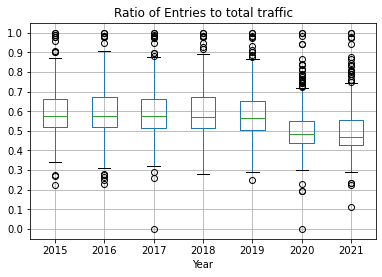

In [11]:
week_station.boxplot(column=['ratio'],by='Year')
plt.title('Ratio of Entries to total traffic')
plt.yticks(np.linspace(0,1,11))
plt.suptitle('')
plt.savefig('boxplot.png')
plt.show()

Use year 2019 as the base reference, 

We will seperate out the data in June 2019 as reference, then merge the dataframe with all the data after 2019, so we can compare the data in other years with data in 2020.

In [18]:
week_rec=pd.read_sql('''
SELECT rec.UNIT,rec.Year,rec.Week, rec.Ent, 
     rec.Ext,ref.Ent Entref, ref.Ext Extref
FROM (SELECT UNIT,Year,Week,SUM(ENTRIES) Ent, SUM(EXITS) Ext
	 FROM mta_station 
	 WHERE Year >=2019
	 GROUP BY UNIT,Year,Week) 
	 AS rec 
JOIN 
     (SELECT UNIT,SUM(ENTRIES) Ent, SUM(EXITS) Ext
	 FROM mta_station 
	 WHERE Year=2019 AND Week=23
	 GROUP BY UNIT) 
	 AS ref
ON	rec.UNIT=ref.UNIT;''', engine)
pd.read_sql('''SELECT UNIT,Year,Week, SUM(ENTRIES) Ent, SUM(EXITS) Ext
FROM mta_station 
WHERE Year >= 2019 
GROUP BY UNIT,Year,Week;''', engine)
week_rec

,UNIT,Year,Week,Ent,Ext,Entref,Extref
0,R001,2019,23,211718,179244,211718,179244
1,R001,2019,48,198224,167642,211718,179244
2,R001,2020,23,18800,21732,211718,179244
3,R001,2020,48,34686,36183,211718,179244
4,R001,2021,22,60604,70050,211718,179244
...,...,...,...,...,...,...,...
2337,R572,2019,23,125802,90288,125802,90288
2338,R572,2019,48,118448,81761,125802,90288
2339,R572,2020,23,19458,17990,125802,90288
2340,R572,2020,48,32220,31232,125802,90288


In [20]:
week_rec['Total']=week_rec['Ent']+week_rec['Ext']
week_rec['Totalref']=week_rec['Entref']+week_rec['Extref']
week_rec['ratio_diff']=week_rec['Ent']/week_rec['Total'] - (week_rec['Entref']/week_rec['Totalref'])

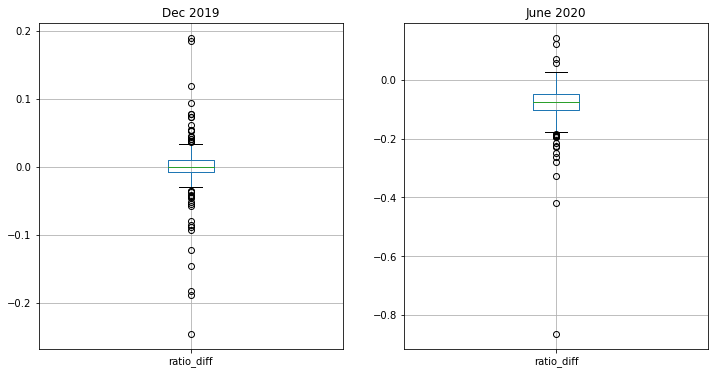

In [21]:
left1 = week_rec[(week_rec['Year']==2019) & (week_rec['Week']==48)]
right1 = week_rec[(week_rec['Year']==2020) & (week_rec['Week']==23)]
plt.figure(figsize=[12,6])
plt.suptitle('')
plt.subplot(1,2,1)
plt.title('Dec 2019')
left1.boxplot(column=['ratio_diff'])
plt.subplot(1,2,2)
right1.boxplot(column=['ratio_diff'])
plt.title('June 2020')
plt.savefig('Dboxplot.png',dpi=150)
plt.show()

We then look at the change in the ratio across the stations. We can see many stations are seeing the shift in rations. About 50% of the stations, are seeing a change anywhere from 5% to 10% change. We will next try to examine the change in net traffic terms, rather than in ratio terms. 

We know check the change in net traffic flow in 2019 compared to 2020.

In [24]:
week_rec['Net']=week_rec.Ent-week_rec.Ext
week_rec['Net_diff']=week_rec.Net-(week_rec.Entref-week_rec.Extref)
week_rec[(week_rec.Year==2019)&(week_rec.Week==23)].Net.sum()

7277640

In [25]:
week_rec[(week_rec.Year==2020) & (week_rec.Week==23)].Net.sum()

-218028

We then sum up the change of net traffic, and it is 7.5 million, across 470 stations.

In [26]:
current=week_rec[(week_rec.Year==2020) & (week_rec.Week==23)].Net_diff
len(current)

469

We check the sum of the top 68 stations with most changes, it is -3.8 million.

In [27]:
current.sort_values()[0:68].sum()

-3789128

We check the sum of the remaining stations, it is -3.7 million.

In [28]:
current.sort_values()[68:].sum()

-3706540

We then get a list of statons and see which statons have the msot changes.

In [29]:
current.sort_values()

152    -124117
52     -114477
47     -107283
62      -90743
102     -83168
         ...  
2264     17540
57       42276
197      43666
2224     46207
147      85254
Name: Net_diff, Length: 469, dtype: int64

In [62]:
week_rec.loc[152,'UNIT']

'R033'

In [36]:
week_rec.loc[147,'UNIT']

'R032'

From the table we see R033 station is "42 ST-TIMES SQ", Time Square station, and
and R012 is "34 ST-PENN STA", The train Station Penn Station.